This notebook is used to cluster the features.

In [31]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# Requried to print df
from IPython.display import display

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "grid.alpha" : 0,
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.bottom" : False,
    "axes.spines.right" : False,
    "axes.spines.left" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,
})

%matplotlib inline
pd.set_option('display.max_colwidth', None)


In [32]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 32
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = mean_key
dataset = "data.csv"
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/{n_features}features/{key if extra_path else '' }"
print(path_models)
print(path)

models/32features/mean/
data/32features/mean/


In [33]:
# Load the dataset without the target feature, thus we remove survive7Y
df = pd.read_csv(f"{path}{dataset}", index_col=0, decimal='.')
df = df.iloc[:, :-1]

### Feature Clustering Using Correlation Matrix

In [34]:
corr = df.corr(method='pearson').abs()
threshold = 0.3
df_cluster = pd.DataFrame()

# For each column we sort the column's and get the top correlated columns by setting a threshold,
# and save the result in a df
for col_name in corr.columns:
    corr_col = corr[col_name].sort_values(ascending=False)[1:]
    corr_col = corr_col[corr_col >= threshold]
    corr_series = pd.DataFrame([",".join([x+"_"+("%.2f" % y) for (x,y) in list(zip(corr_col.index.values, corr_col.values))])], index=[col_name], columns=["correlated_columns"])
    df_cluster = pd.concat([df_cluster,corr_series])
    # print(corr_series.index.values[0])
    # print(corr_series.values[0][0])
    # print("\n")
# df_cluster.to_csv(f"data/data/features_clustering/feat_cluster_{threshold}.csv")
#df_cluster.head()
display(df_cluster)

,correlated_columns
Gender (Male = 1),
Age,
TSH,Ipotiroidismo_0.55
fT3,"fT4_0.54,Ipertiroidismo_0.51"
fT4,"fT3_0.54,Ipertiroidismo_0.54"
Euthyroid,"Low T3_0.70,Subclinical primary hypothyroidism (SCH)_0.40"
Subclinical primary hypothyroidism (SCH),Euthyroid_0.40
Subclinical primary hyperthyroidism\n(SCT),
Low T3,Euthyroid_0.70
Ipotiroidismo,TSH_0.55


Correlation (>= 0.3) size: 30.0 / 930


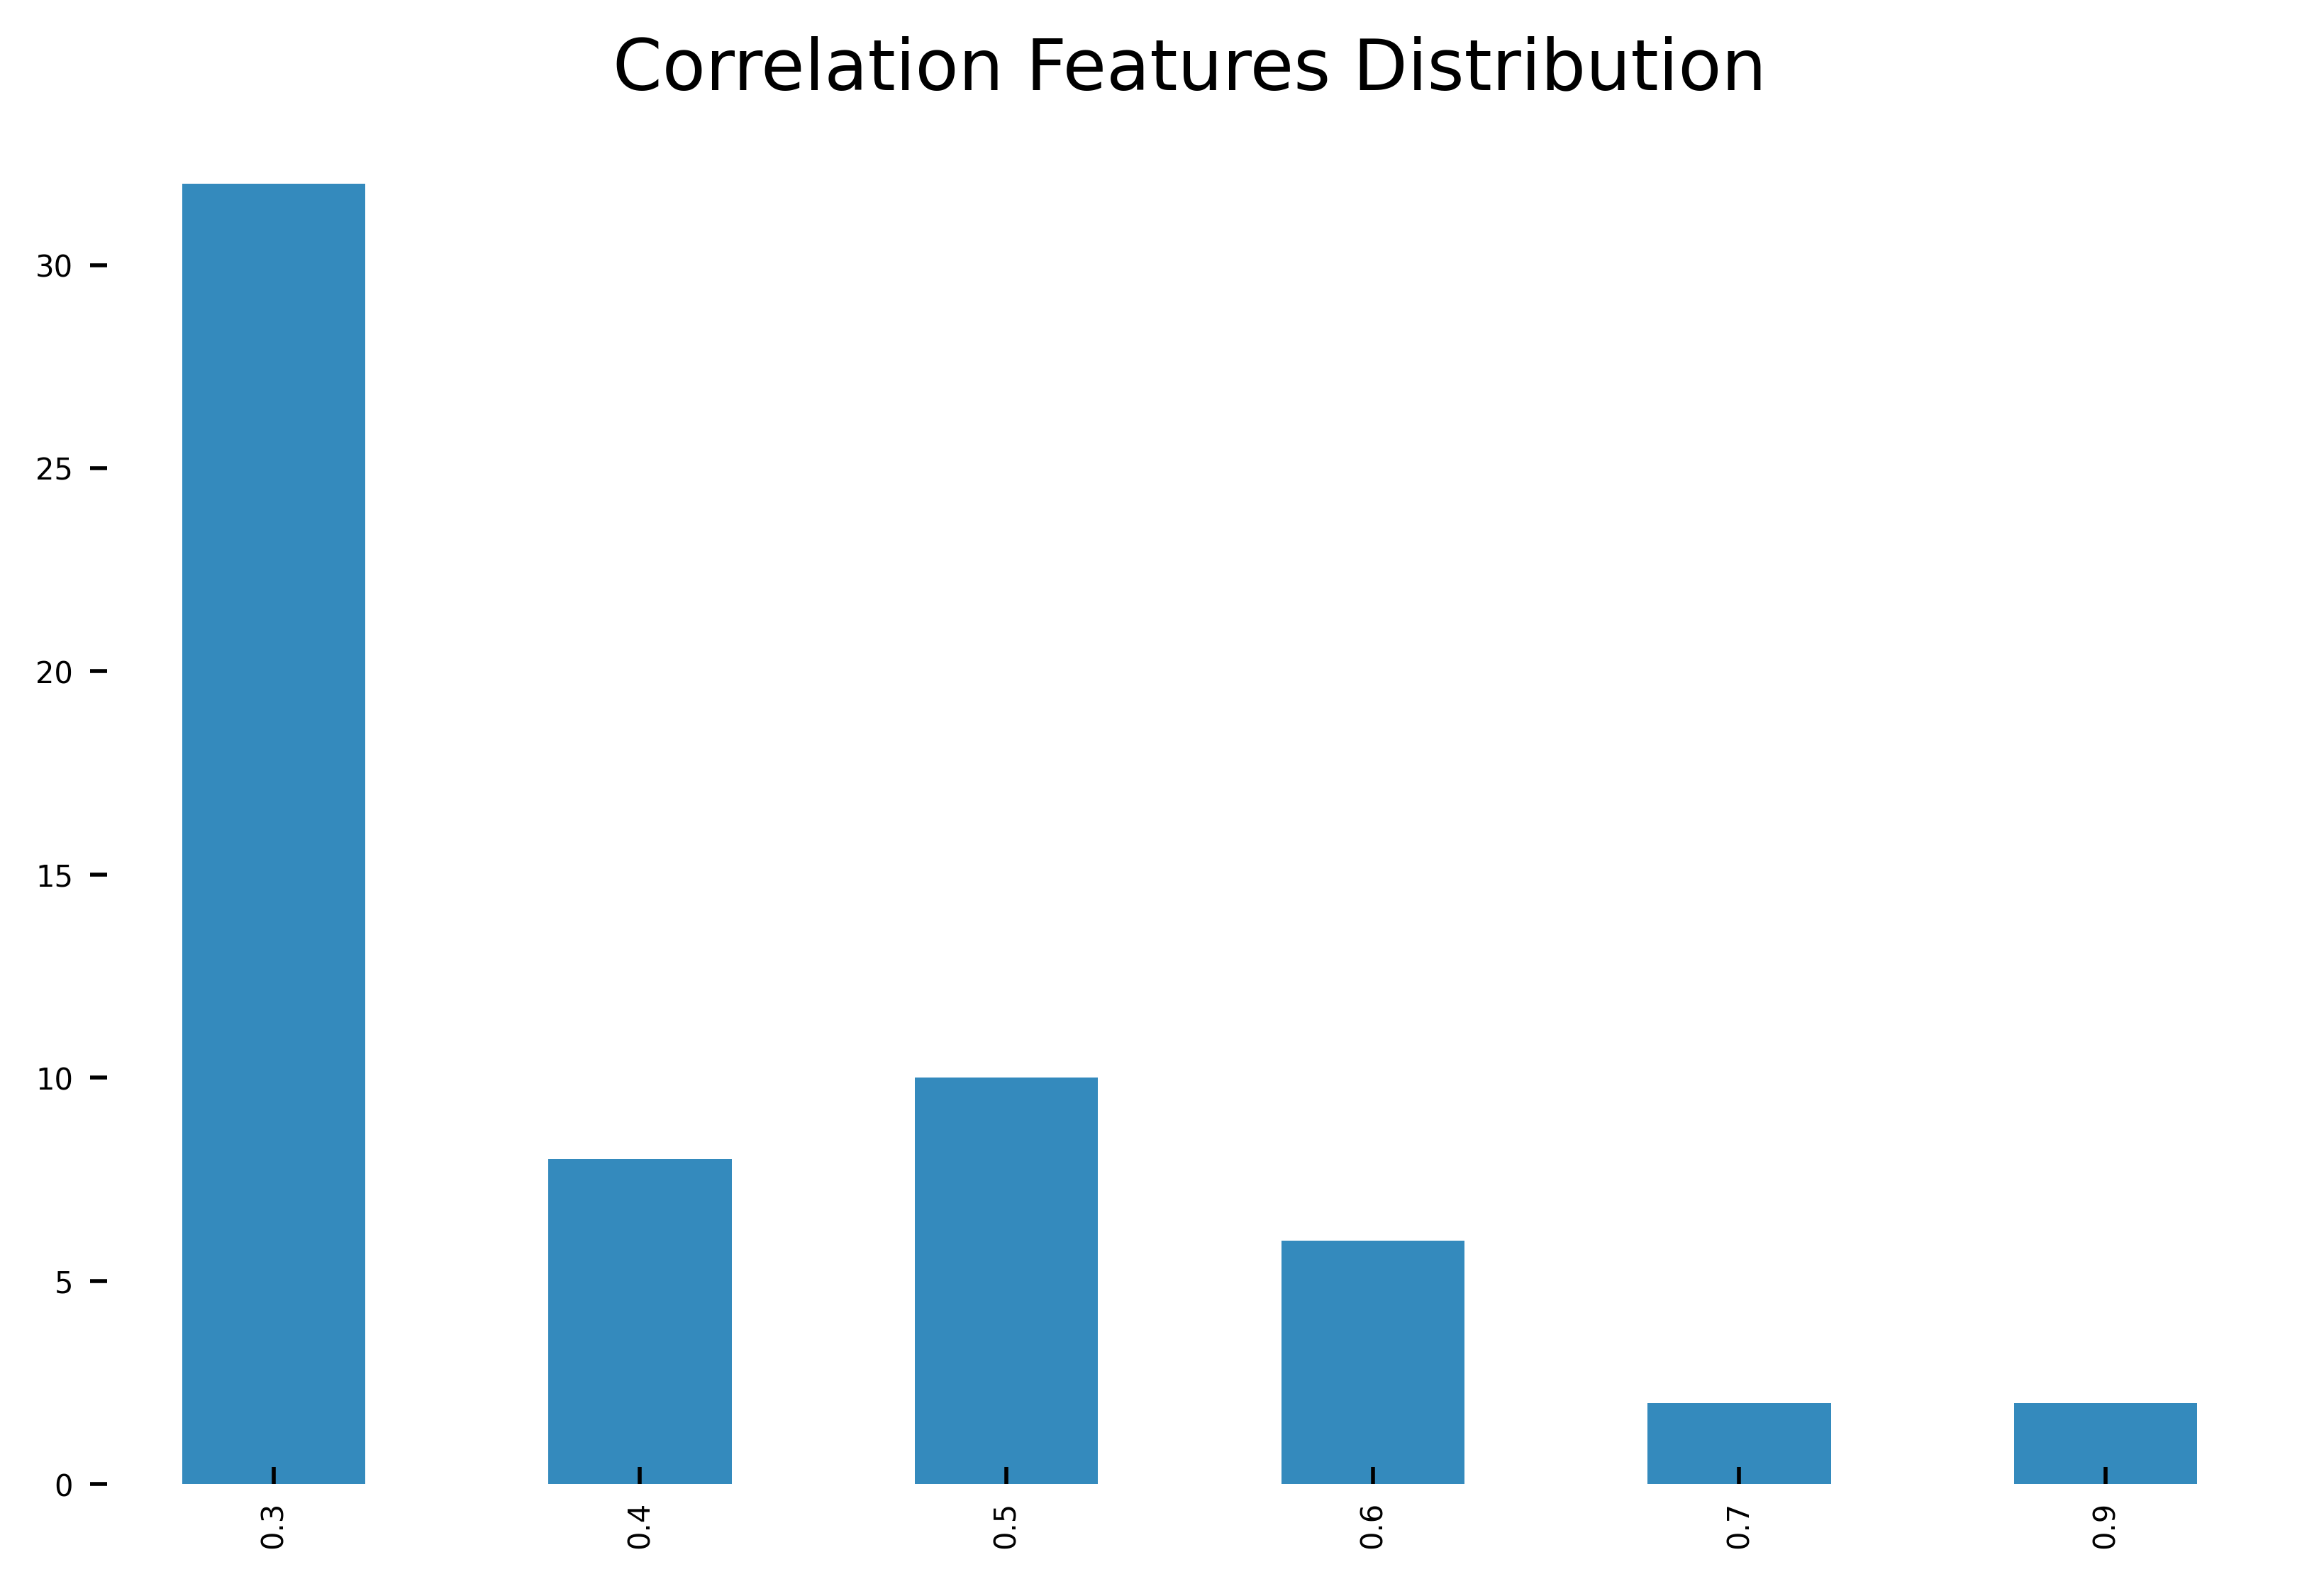

In [35]:
corr1D = pd.Series(corr.values.flatten())
corr1D = corr1D[corr1D != 1]
corr1D = corr1D.map(lambda x: round(x, 1))
corr_dist = corr1D.value_counts().sort_index()
corr_dist = corr_dist[corr_dist.index >= threshold]
corr_dist.plot(kind="bar", fontsize=6)
plt.title("Correlation Features Distribution")

print(f"Correlation (>= {threshold}) size: {corr_dist[corr_dist.index >= threshold].sum()/2} / {len(corr1D/2)}")

### Feature Clustering Using Correlation Matrix + Hierarchical Clustering
[Clustering using a matrix of correlation coeff](https://stackoverflow.com/questions/38070478/how-to-do-clustering-using-the-matrix-of-correlation-coefficients)

[S v P](https://stats.stackexchange.com/questions/8071/how-to-choose-between-pearson-and-spearman-correlatio) considerations
- Spearman checks only the monotonic relationships (less assumptions, more resistant to outliers)
- Pearson checks the linear relationships

In [36]:
df.columns

Index(['Gender (Male = 1)', 'Age', 'TSH', 'fT3', 'fT4', 'Euthyroid',
       'Subclinical primary hypothyroidism (SCH)',
       'Subclinical primary hyperthyroidism\n(SCT)', 'Low T3', 'Ipotiroidismo',
       'Ipertiroidismo', 'Angina', 'Previous CABG', 'Previous PCI',
       'Previous Myocardial Infarction', 'Acute Myocardial Infarction',
       'Angiography', 'Vessels', 'Documented resting \nor exertional ischemia',
       'Post-ischemic Dilated\nCardiomyopathy', 'Smoke\nHistory of smoke',
       'Diabetes\nHistory of diabetes',
       'Hypertension\nHistory of hypertension',
       'Dyslipidemia\nHystory of dyslipidemia', 'Atrial Fibrillation', 'fe',
       'Total cholesterol', 'HDL', 'LDL', 'Triglycerides', 'Creatinina'],
      dtype='object')

In [37]:
df = df.rename(columns={
    "Smoke\nHistory of smoke": "Smoke",
    "Diabetes\nHistory of diabetes": "Diabetes",
    "Hypertension\nHistory of hypertension": "Hypertension",
    "Dyslipidemia\nHystory of dyslipidemia": "Dyslipidemia",
    "fe": "LVEF",
    "Gender (Male = 1)": "Gender",
    "Previous Myocardial Infarction": "Previous MI",
    "Previous PCI": "PCI",
    "Acute Myocardial Infarction": "Acute MI",
    "Post-ischemic Dilated\nCardiomyopathy": "Post IDC",
})

Number of clusters: 10


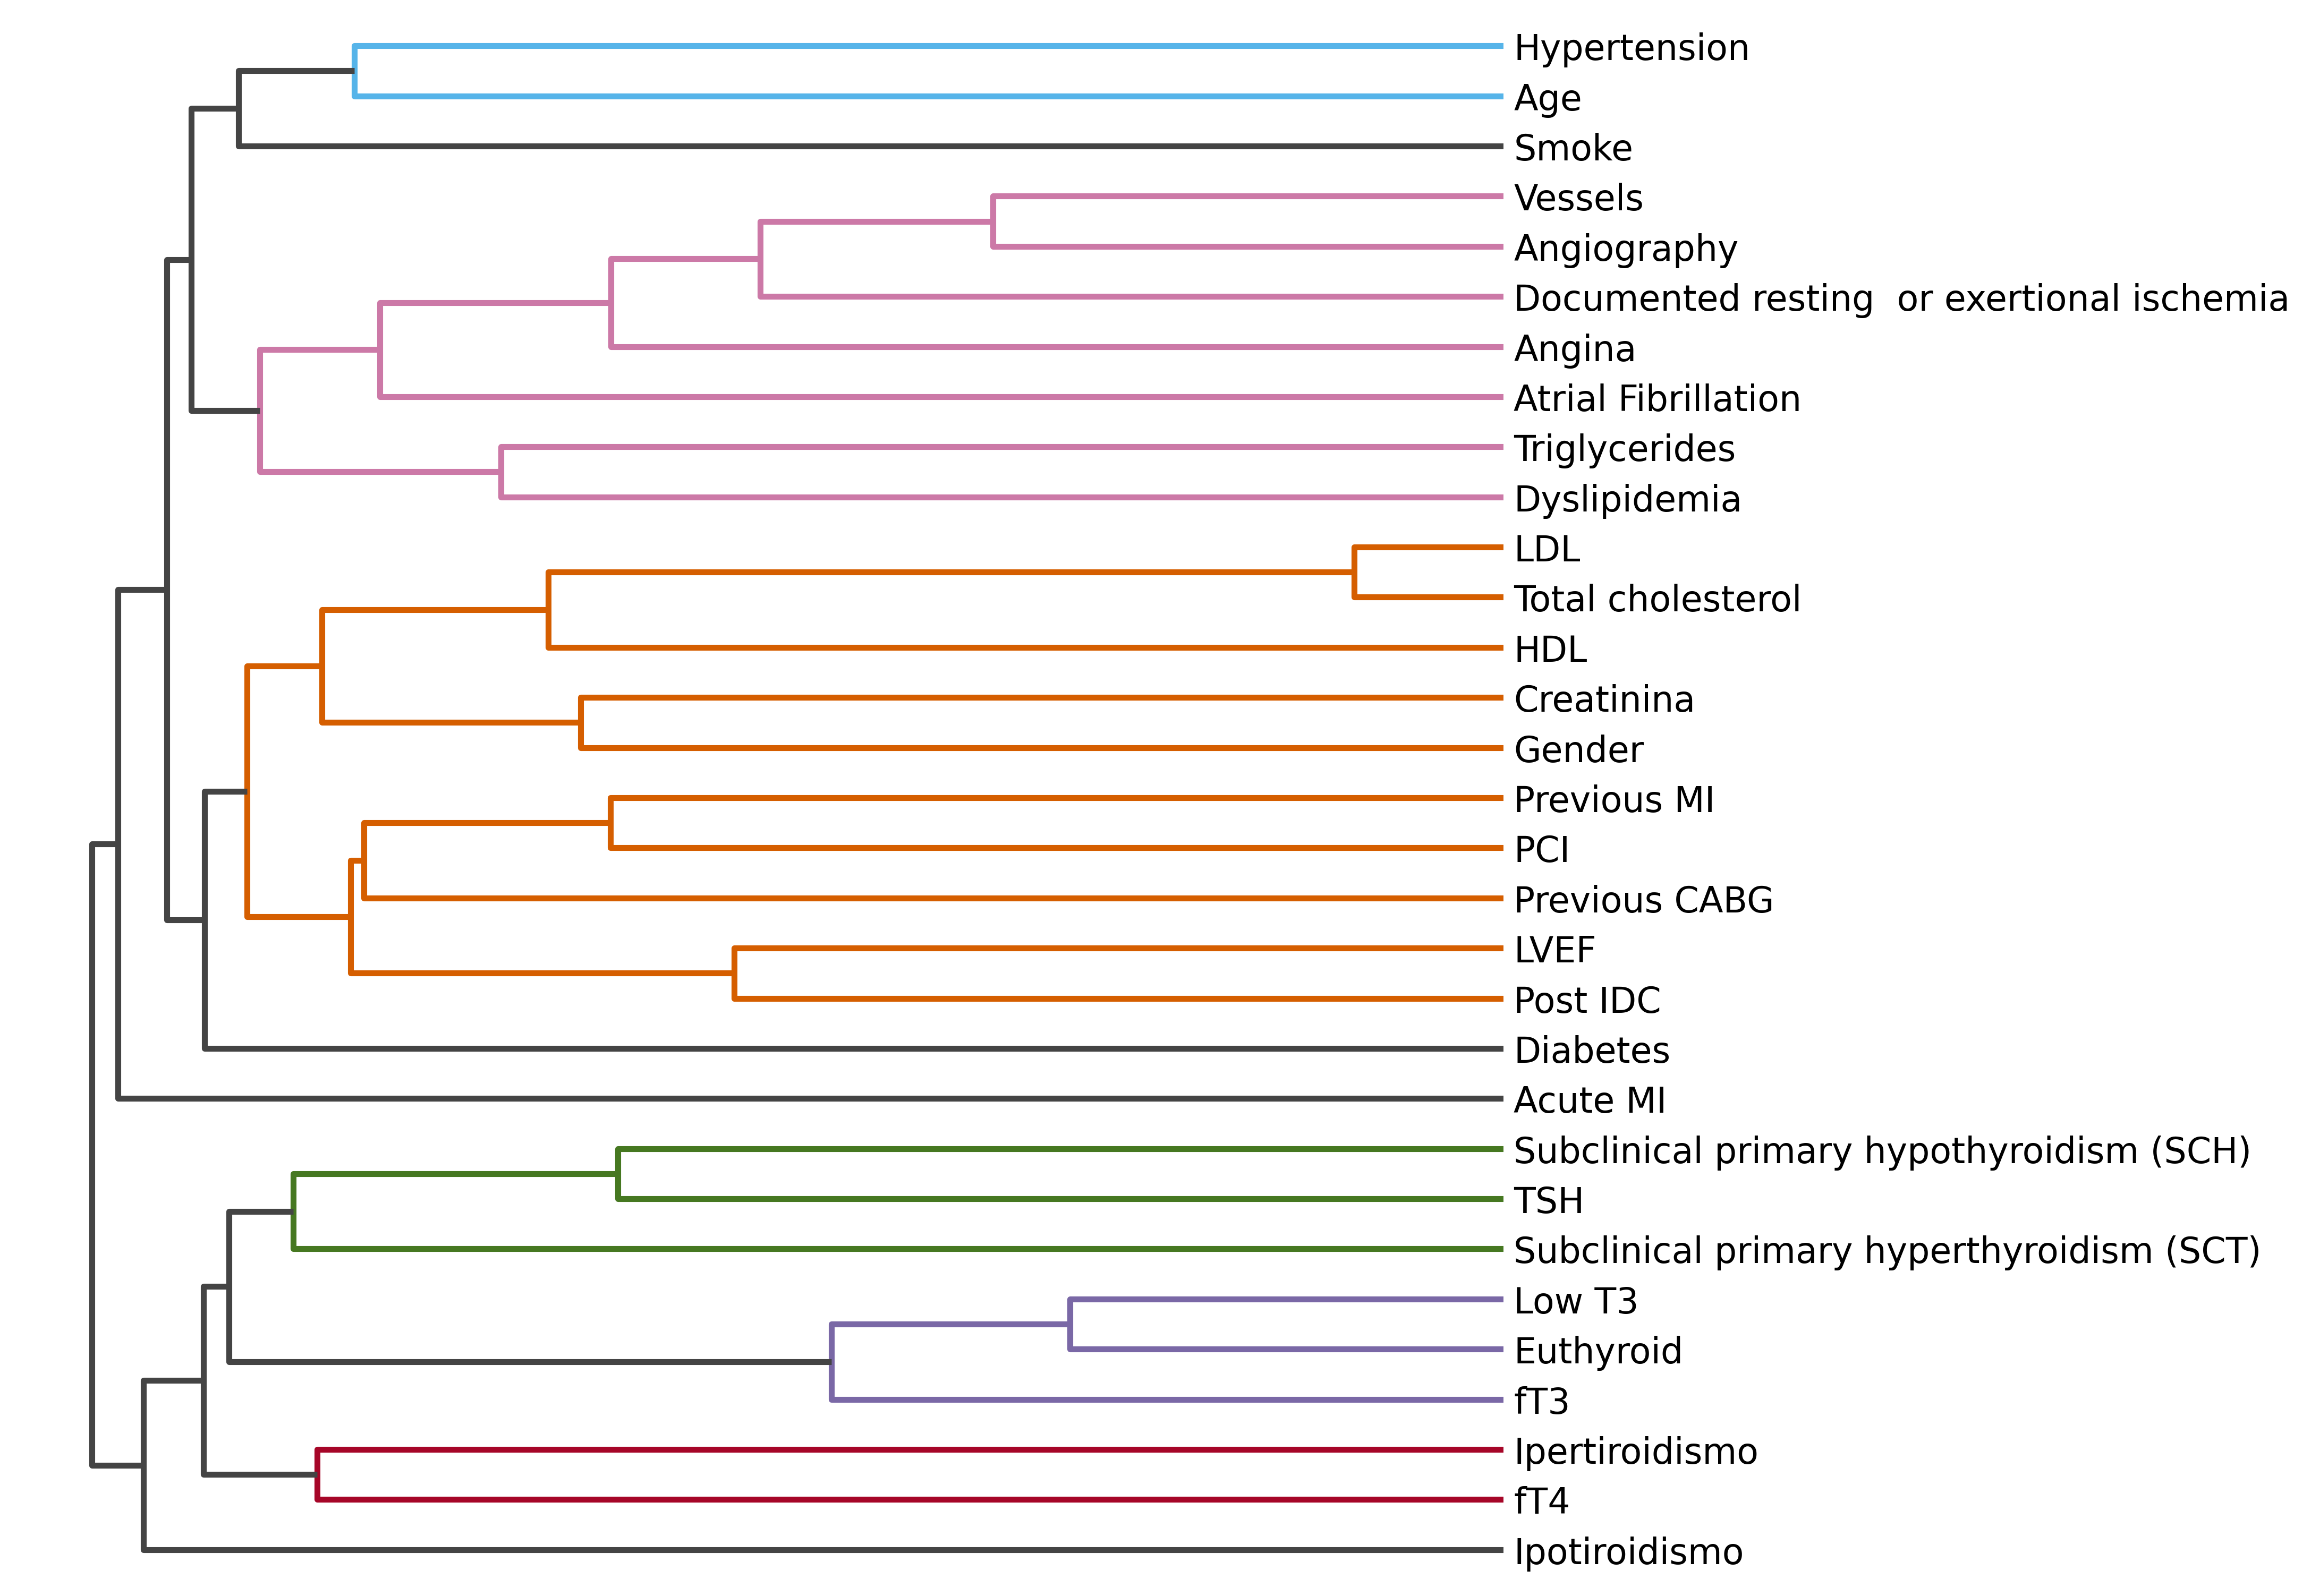

In [38]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
# Spearman is more robust to outliers and non-linear relationships compared to Pearson.
# 1) Compute the correlation (similarity) and distance (dissimilarity)
corr = df.corr(method="spearman")  
dist = 1 - corr.abs()

# 2) Transform the distance matrix into a condensed distance vector
# Default metric is eucliden
#dist_condense = pdist(dist)
dist_condensed= squareform(dist)
# 3) Create the hierarchical clustering using the condensend distance vector
hier = hierarchy.linkage(dist_condensed, method="weighted")
threshold = 0.87
cluster_labels = hierarchy.fcluster(hier, threshold, criterion="distance")
print(f"Number of clusters: {len(set(cluster_labels))}")

# Plot
# Choose threshold using dendrogram or any other method (e.g. quantile or desired number of features)
plt.figure(figsize=(9, 9.5), dpi=400)
# plt.title("Hierarchy Clustering of Features")
plt.tick_params(labelbottom=False, bottom=False)
dend = hierarchy.dendrogram(
    hier, 
    truncate_mode="level", 
    p=30, 
    color_threshold=threshold, 
    above_threshold_color='#444444',
    labels= [column.replace("\n"," ") for column in corr.columns], 
    orientation="left", 
    leaf_font_size=12
)
plt.savefig(f"./{path_images}cluster.tiff", format="tiff", dpi=400, bbox_inches="tight")

In [39]:
# Save each group feature
df_cluster = pd.DataFrame({'ClusterID': cluster_labels,
                           'Feature': df.columns})
df_cluster = df_cluster.groupby(['ClusterID'])
df_cluster = df_cluster['Feature'].apply(lambda x: list(x)).reset_index()['Feature']
display(df_cluster.to_pickle)
df_cluster.to_pickle(f'{path_images}feat_cluster_hier.df')

<bound method NDFrame.to_pickle of 0                                                                                                            [fT4, Ipertiroidismo]
1                                                                                                         [fT3, Euthyroid, Low T3]
2                                      [TSH, Subclinical primary hypothyroidism (SCH), Subclinical primary hyperthyroidism\n(SCT)]
3                                                                                                                  [Ipotiroidismo]
4                               [Gender, Previous CABG, PCI, Previous MI, Post IDC, LVEF, Total cholesterol, HDL, LDL, Creatinina]
5                                                                                                                       [Diabetes]
6    [Angina, Angiography, Vessels, Documented resting \nor exertional ischemia, Dyslipidemia, Atrial Fibrillation, Triglycerides]
7                                               

In [40]:
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import silhouette_score
# Cophenet correlation measure how faithfully the dendrogram preserves the original data point's distance
# Cophenet = optimal when -> 1
# https://en.wikipedia.org/wiki/Cophenetic_correlation
#c, coph_dists = cophenet(hier, pdist(dist))
#c
silhouette_score(dist , cluster_labels, metric='precomputed')

0.11022452509354219